In [20]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [2]:
# Download stopwords if not available
nltk.download('stopwords')
# Set stopwords
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
def load_jsonl(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)
# Load training and validation data
train_df = load_jsonl('train.jsonl')
val_df = load_jsonl('validation.jsonl')

In [4]:
train_df.head()

,uuid,postId,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,targetKeywords,targetMedia,targetUrl,provenance,spoiler,spoilerPositions,tags
0,0af11f6b-c889-4520-9372-66ba25cb7657,532quh,"[Wes Welker Wanted Dinner With Tom Brady, But ...",reddit,[It’ll be just like old times this weekend for...,"Wes Welker Wanted Dinner With Tom Brady, But P...",It'll be just like old times this weekend for ...,"new england patriots, ricky doyle, top stories,","[http://pixel.wp.com/b.gif?v=noscript, http://...",http://nesn.com/2016/09/wes-welker-wanted-dinn...,"{'source': 'anonymized', 'humanSpoiler': 'They...",[how about that morning we go throw?],"[[[3, 151], [3, 186]]]",[passage]
1,b1a1f63d-8853-4a11-89e8-6b2952a393ec,411701128456593408,[NASA sets date for full recovery of ozone hole],Twitter,[2070 is shaping up to be a great year for Mot...,Hole In Ozone Layer Expected To Make Full Reco...,2070 is shaping up to be a great year for Moth...,"ozone layer,ozone hole determined by weather,M...",[http://s.m.huffpost.com/assets/Logo_Huffingto...,http://huff.to/1cH672Z,"{'source': 'anonymized', 'humanSpoiler': '2070...",[2070],"[[[0, 0], [0, 4]]]",[phrase]
2,008b7b19-0445-4e16-8f9e-075b73f80ca4,380537005123190784,[This is what makes employees happy -- and it'...,Twitter,"[Despite common belief, money isn't the key to...",Intellectual Stimulation Trumps Money For Empl...,By: Chad Brooks \r\nPublished: 09/18/2013 06:4...,"employee happiness money,employee happiness in...",[http://i.huffpost.com/gen/1359674/images/o-HA...,http://huff.to/1epfeaw,"{'source': 'anonymized', 'humanSpoiler': 'Inte...",[intellectual stimulation],"[[[1, 186], [1, 210]]]",[phrase]
3,31ecf93c-3e21-4c80-949b-aa549a046b93,844567852531286016,[Passion is overrated — 7 work habits you need...,Twitter,"[It’s common wisdom. Near gospel really, and n...","‘Follow your passion’ is wrong, here are 7 hab...",There's a lot more to work that loving your job,"business, work-life, careers",None,None,"{'source': 'anonymized', 'humanSpoiler': None,...",[Purpose connects us to something bigger and i...,"[[[11, 25], [11, 101]], [[17, 56], [17, 85]], ...",[multi]
4,31b108a3-c828-421a-a4b9-cf651e9ac859,814186311573766144,[The perfect way to cook rice so that it's per...,Twitter,"[Boiling rice may seem simple, but there is a ...",Revealed: The perfect way to cook rice so that...,The question 'How does one cook rice properly?...,"Quora,users,share,perfect,way,cook,rice",None,None,"{'source': 'anonymized', 'humanSpoiler': None,...",[in a rice cooker],"[[[5, 60], [5, 76]]]",[phrase]


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   uuid               3200 non-null   object
 1   postId             3200 non-null   object
 2   postText           3200 non-null   object
 3   postPlatform       3200 non-null   object
 4   targetParagraphs   3200 non-null   object
 5   targetTitle        3200 non-null   object
 6   targetDescription  2933 non-null   object
 7   targetKeywords     2116 non-null   object
 8   targetMedia        2685 non-null   object
 9   targetUrl          2717 non-null   object
 10  provenance         3200 non-null   object
 11  spoiler            3200 non-null   object
 12  spoilerPositions   3200 non-null   object
 13  tags               3200 non-null   object
dtypes: object(14)
memory usage: 350.1+ KB


In [6]:
print("Missing Values:\n", train_df.isnull().sum())

Missing Values:
 uuid                    0
postId                  0
postText                0
postPlatform            0
targetParagraphs        0
targetTitle             0
targetDescription     267
targetKeywords       1084
targetMedia           515
targetUrl             483
provenance              0
spoiler                 0
spoilerPositions        0
tags                    0
dtype: int64


In [7]:
print("Missing Values:\n", val_df.isnull().sum())

Missing Values:
 uuid                   0
postId                 0
postText               0
postPlatform           0
targetParagraphs       0
targetTitle            0
targetDescription     70
targetKeywords       290
targetMedia          125
targetUrl            117
provenance             0
spoiler                0
spoilerPositions       0
tags                   0
dtype: int64


In [8]:
# Select relevant columns
columns_to_keep = ['postText', 'tags']
train_df = train_df[columns_to_keep]
val_df = val_df[columns_to_keep]

In [9]:
# Function to preprocess data
def preprocess_data(df):
    df = df.dropna()  # Remove NaN values

    # Convert list columns to strings
    df['postText'] = df['postText'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else "")
    df['tags'] = df['tags'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else "")

    return df

# Apply preprocessing
train_df = preprocess_data(train_df)
val_df = preprocess_data(val_df)

In [10]:
# Extract text features and labels
X_train = train_df['postText']
y_train = train_df['tags']
X_valid = val_df['postText']
y_valid = val_df['tags']
# Remove empty strings
X_train = X_train.dropna().astype(str)
X_train = X_train[X_train.str.strip() != ""]
X_valid = X_valid.dropna().astype(str)
X_valid = X_valid[X_valid.str.strip() != ""]

In [11]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_train_tfidf = vectorizer.fit_transform(X_train)
X_valid_tfidf = vectorizer.transform(X_valid)
# Check vocabulary size
print(f"Vocabulary size: {len(vectorizer.get_feature_names_out())}")

Vocabulary size: 5000


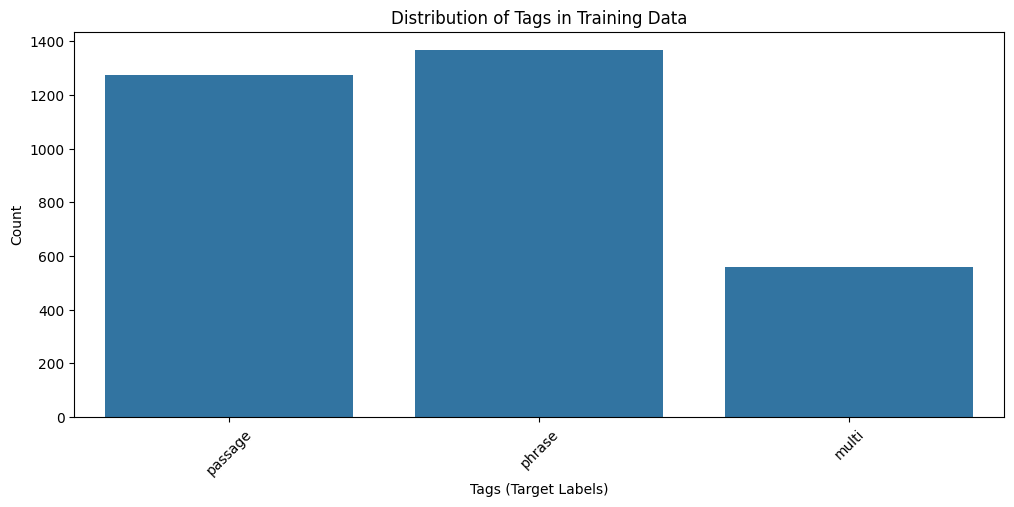

In [12]:
# Plot class distribution
plt.figure(figsize=(12, 5))
sns.countplot(x=train_df['tags'])
plt.xticks(rotation=45)
plt.xlabel("Tags (Target Labels)")
plt.ylabel("Count")
plt.title("Distribution of Tags in Training Data")
plt.show()

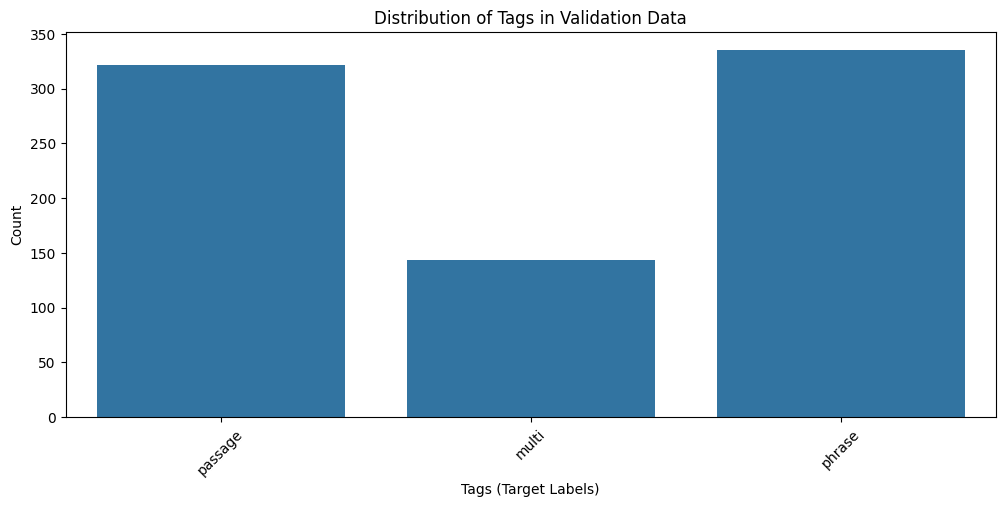

In [13]:
# Distribution of Tags in Validation Data
plt.figure(figsize=(12, 5))
sns.countplot(x=val_df['tags'])
plt.xticks(rotation=45)
plt.xlabel("Tags (Target Labels)")
plt.ylabel("Count")
plt.title("Distribution of Tags in Validation Data")
plt.show()

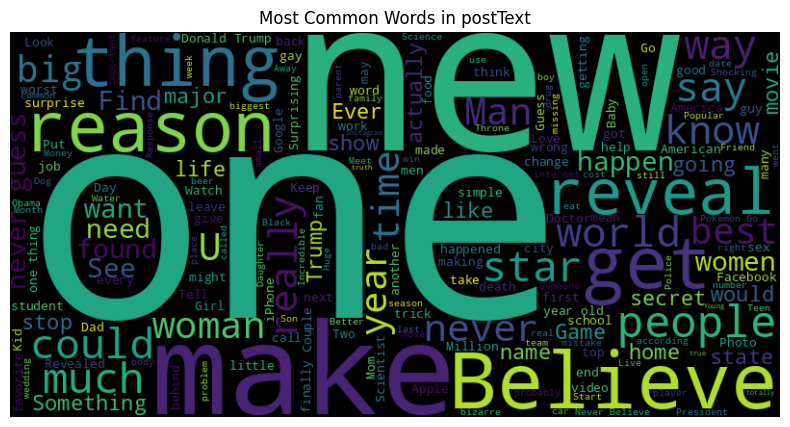

In [15]:
# Visualize the most common words in postText
from wordcloud import WordCloud

text = " ".join(train_df['postText'].dropna())
wordcloud = WordCloud(width=800, height=400, stopwords=stop_words, background_color='black').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in postText")
plt.show()

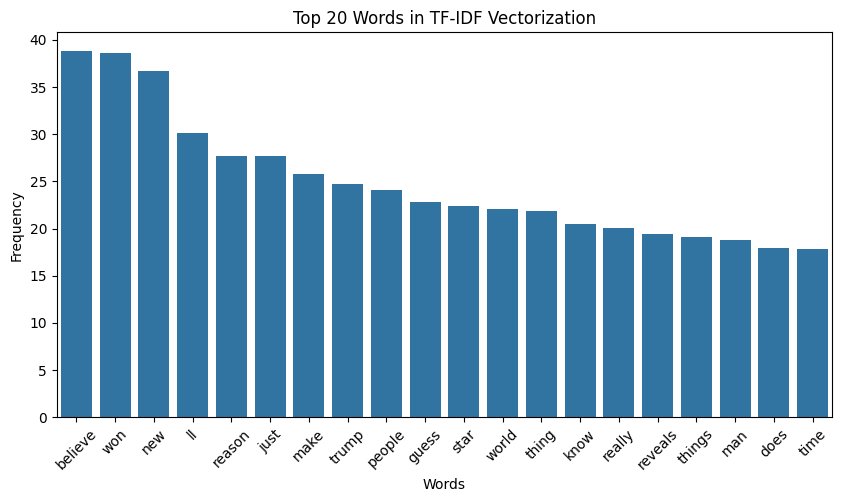

In [17]:
import numpy as np
# Bar plot for top words in TF-IDF vocabulary
feature_names = vectorizer.get_feature_names_out()
word_frequencies = np.array(X_train_tfidf.sum(axis=0)).flatten()
top_n = 20
top_words = np.argsort(word_frequencies)[::-1][:top_n]
plt.figure(figsize=(10, 5))
sns.barplot(x=[feature_names[i] for i in top_words], y=[word_frequencies[i] for i in top_words])
plt.xticks(rotation=45)
plt.title("Top 20 Words in TF-IDF Vectorization")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

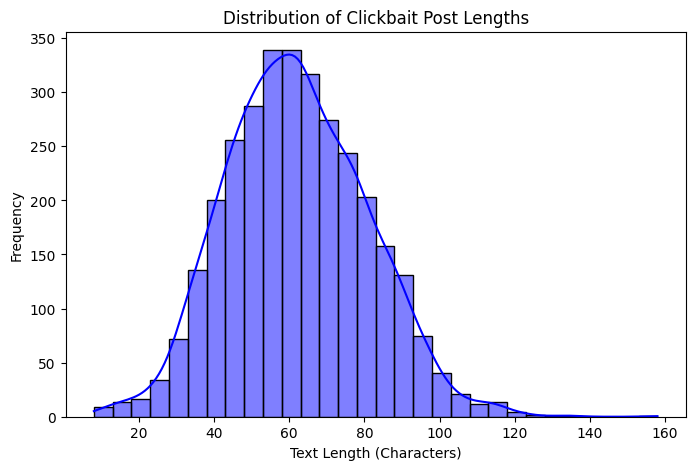

In [18]:
### Text Length Distribution of Clickbait Posts
train_df["post_length"] = X_train.apply(len)
plt.figure(figsize=(8, 5))
sns.histplot(train_df["post_length"], bins=30, kde=True, color="blue")
plt.xlabel("Text Length (Characters)")
plt.ylabel("Frequency")
plt.title("Distribution of Clickbait Post Lengths")
plt.show()

In [21]:
# Encode target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_valid_encoded = label_encoder.transform(y_valid)

# Convert labels to one-hot encoding
num_classes = len(label_encoder.classes_)
y_train_onehot = to_categorical(y_train_encoded, num_classes)
y_valid_onehot = to_categorical(y_valid_encoded, num_classes)

In [22]:
# Tokenize and pad sequences
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 100
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_valid_seq = tokenizer.texts_to_sequences(X_valid)
X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_valid_padded = pad_sequences(X_valid_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')


In [25]:
# Function to evaluate models
def evaluate_model(model, X_valid_padded, y_valid_encoded, model_name):
    y_pred = np.argmax(model.predict(X_valid_padded), axis=1)
    accuracy = accuracy_score(y_valid_encoded, y_pred)
    print(f"\n {model_name} Model Performance:")
    print(f"Accuracy: {accuracy:.4f}\n")
    print(classification_report(y_valid_encoded, y_pred, zero_division=0))
    # Confusion Matrix
    cm = confusion_matrix(y_valid_encoded, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()
    return accuracy


Training Baseline Model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.3971 - loss: 1.0529 - val_accuracy: 0.5263 - val_loss: 1.0102
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6686 - loss: 0.9090 - val_accuracy: 0.5175 - val_loss: 0.9554
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7967 - loss: 0.4913 - val_accuracy: 0.5900 - val_loss: 0.9659
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9448 - loss: 0.2233 - val_accuracy: 0.5738 - val_loss: 1.0984
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9928 - loss: 0.0619 - val_accuracy: 0.5713 - val_loss: 1.1604
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9977 - loss: 0.0252 - val_accuracy: 0.5813 - val_loss: 1.1772
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9994 - loss: 0.0110 - val_accuracy: 0.5763 - val_loss: 1.2313
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9980 - loss: 0.0105 - val_accu

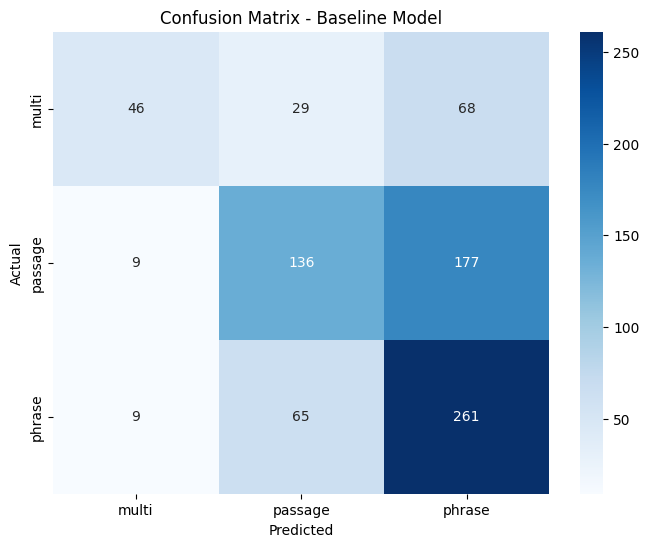

In [26]:
# Dictionary to store accuracy scores
model_accuracies = {}
### Baseline Model (Simple Neural Network) ###
print("\nTraining Baseline Model...")
baseline_model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=64, input_length=MAX_SEQUENCE_LENGTH),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
baseline_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
baseline_model.fit(X_train_padded, y_train_onehot, epochs=20, batch_size=32, validation_data=(X_valid_padded, y_valid_onehot), verbose=1)
# Evaluate Baseline Model
model_accuracies["Baseline Model"] = evaluate_model(baseline_model, X_valid_padded, y_valid_encoded, "Baseline Model")


Training CNN Model...
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.4211 - loss: 1.0430 - val_accuracy: 0.4187 - val_loss: 1.0359
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5372 - loss: 0.9633 - val_accuracy: 0.5412 - val_loss: 0.9731
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.8465 - loss: 0.4224 - val_accuracy: 0.5688 - val_loss: 1.0835
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.9873 - loss: 0.0758 - val_accuracy: 0.5600 - val_loss: 1.3079
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9964 - loss: 0.0179 - val_accuracy: 0.5462 - val_loss: 1.5757
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.9959 - loss: 0.0148 - val_accuracy: 0.5863 - val_loss: 1.4671
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9978 - loss: 0.0090 - val_accuracy: 0.5763 - val_loss: 1.5070
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9989 - loss: 0.0075 - val_accuracy: 0.566

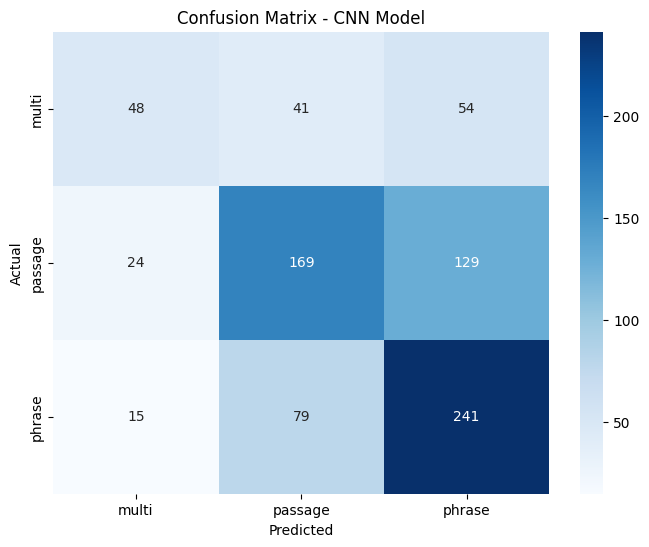

In [28]:
### CNN Model ###
print("\nTraining CNN Model...")
cnn_model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=64, input_length=MAX_SEQUENCE_LENGTH),
    Conv1D(64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
cnn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train_padded, y_train_onehot, epochs=20, batch_size=32, validation_data=(X_valid_padded, y_valid_onehot), verbose=1)
# Evaluate CNN Model
model_accuracies["CNN Model"] = evaluate_model(cnn_model, X_valid_padded, y_valid_encoded, "CNN Model")


Training LSTM Model...
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.4070 - loss: 1.0546 - val_accuracy: 0.4187 - val_loss: 1.0412
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.4364 - loss: 1.0325 - val_accuracy: 0.4025 - val_loss: 1.0392
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.4221 - loss: 1.0355 - val_accuracy: 0.4187 - val_loss: 1.0387
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.4212 - loss: 1.0473 - val_accuracy: 0.4187 - val_loss: 1.0396
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.4366 - loss: 1.0322 - val_accuracy: 0.4025 - val_loss: 1.0392
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.4159 - loss: 1.0383 - val_accuracy: 0.4187 - val_loss: 1.0407
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.4338 - loss: 1.0407 - val_accuracy: 0.4187 - val_loss: 1.0390
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.4050 - loss: 1.0360 - val_accuracy: 0

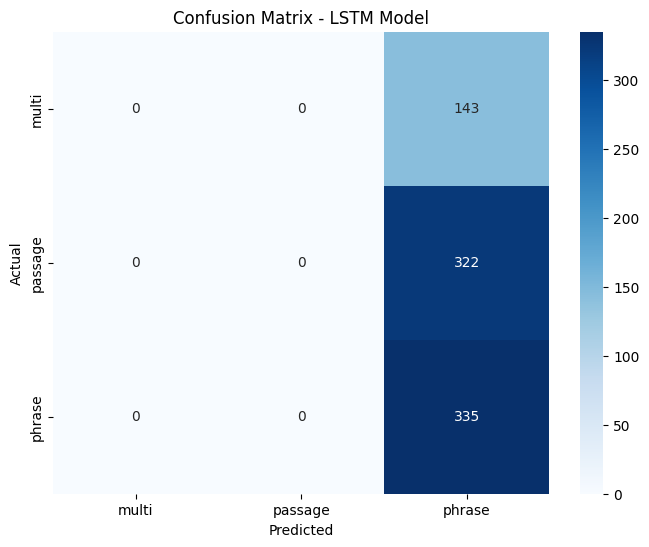

In [29]:
### LSTM Model ###
print("\nTraining LSTM Model...")
lstm_model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=64, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(64, return_sequences=False),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
lstm_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train_padded, y_train_onehot, epochs=20, batch_size=32, validation_data=(X_valid_padded, y_valid_onehot), verbose=1)

# Evaluate LSTM Model
model_accuracies["LSTM Model"] = evaluate_model(lstm_model, X_valid_padded, y_valid_encoded, "LSTM Model")


Training BiLSTM Model...
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 109ms/step - accuracy: 0.4305 - loss: 1.0478 - val_accuracy: 0.5487 - val_loss: 0.9681
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 92ms/step - accuracy: 0.6661 - loss: 0.7943 - val_accuracy: 0.6100 - val_loss: 0.9175
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - accuracy: 0.8730 - loss: 0.3546 - val_accuracy: 0.5600 - val_loss: 1.2215
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.9586 - loss: 0.1505 - val_accuracy: 0.5600 - val_loss: 1.5420
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.9855 - loss: 0.0567 - val_accuracy: 0.5638 - val_loss: 1.9806
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.9856 - loss: 0.0443 - val_accuracy: 0.5500 - val_loss: 2.0608
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - accuracy: 0.9937 - loss: 0.0271 - val_accuracy: 0.5525 - val_loss: 2.1448
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.9976 - loss: 0.0109 - val_a

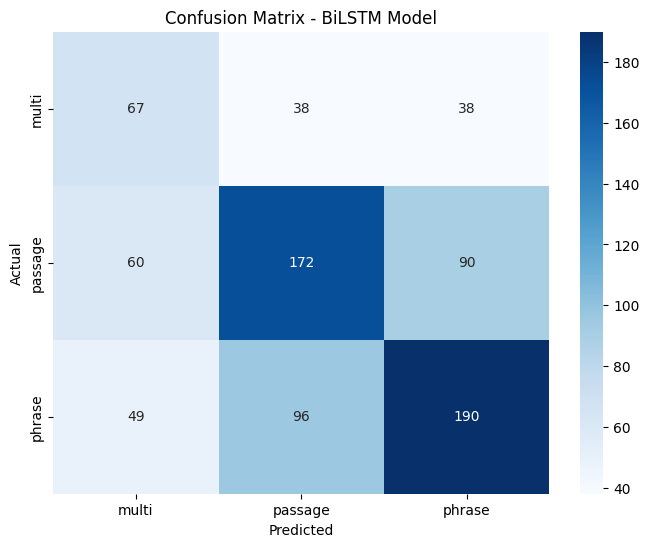

In [30]:
### BiLSTM Model ###
print("\nTraining BiLSTM Model...")
bilstm_model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=64, input_length=MAX_SEQUENCE_LENGTH),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
bilstm_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
bilstm_model.fit(X_train_padded, y_train_onehot, epochs=20, batch_size=32, validation_data=(X_valid_padded, y_valid_onehot), verbose=1)
# Evaluate BiLSTM Model
model_accuracies["BiLSTM Model"] = evaluate_model(bilstm_model, X_valid_padded, y_valid_encoded, "BiLSTM Model")

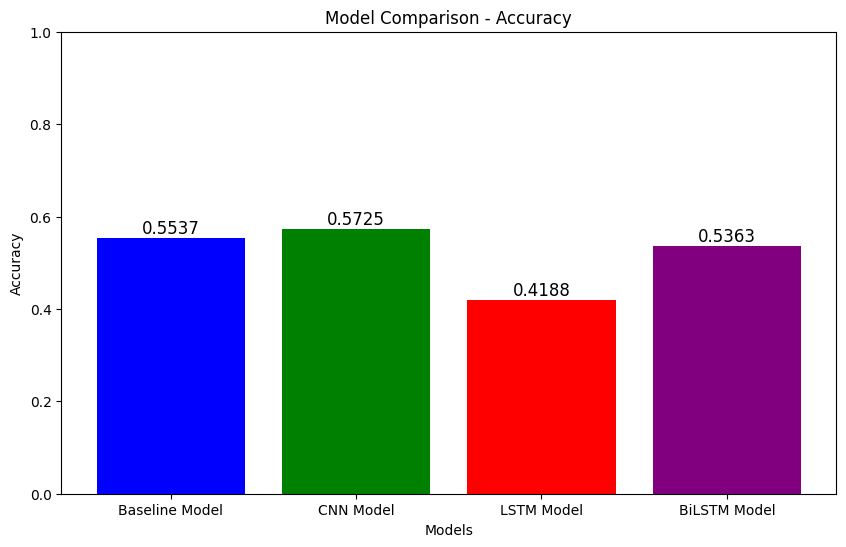

In [31]:
# Model Comparison Bar Plot
plt.figure(figsize=(10, 6))
plt.bar(model_accuracies.keys(), model_accuracies.values(), color=['blue', 'green', 'red', 'purple'])
for i, v in enumerate(model_accuracies.values()):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontsize=12)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Comparison - Accuracy")
plt.ylim(0, 1)
plt.show()